In [2]:

import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import pandas as pd
import seaborn as sns
from ipywidgets import interact
import matplotlib.patches as mpatches
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from functools import cache

# The Model and parameters

In [3]:
r,gamma,epsilon, beta = [0.3/0.7, (0.7*0.05)/0.012, 0.012/0.7, 108/5.7]
constants = [0.3/0.7, (0.7*0.05)/0.012, 0.012/0.7, 108/5.7]
constants

[0.4285714285714286,
 2.9166666666666665,
 0.017142857142857144,
 18.94736842105263]

Numerical integration of equations

$\dot{Z} = 0 $ when either $Z = 0$ or $\Gamma \frac{P^{2}}{1+P^{2}} = 1$, i.e. $P = \sqrt{\frac{1}{\Gamma - 1}}$

$\dot{P} = 0$ when $rP(1-\frac{P}{\beta}) = Z\frac{P^{2}}{1+P^{2}}$. Therefore for $\dot{P} = 0$ we have solutions to the polynomial $P^{3} - \beta P^{2} + \left( 1+ \frac{\beta Z}{r}\right)P - \beta$. There also exist solutions for $P = 0$

This gives 3 fixed points for the system, e1 = (0,0), e2 = ($\beta$,0), e3 = $\left( \sqrt{\frac{1}{\Gamma - 1}}, \frac{r \Gamma (\beta \sqrt{\Gamma - 1} - 1)}{\beta(\Gamma -1)}\right)$

In [4]:
equilibria = np.array([ [0 , 0],
              [constants[3] , 0],
              [np.sqrt(1/(gamma-1)) , (r*gamma*(beta*np.sqrt(gamma - 1) - 1))/( beta*(gamma - 1) )] ])
equilibria

array([[ 0.        ,  0.        ],
       [18.94736842,  0.        ],
       [ 0.72231512,  0.86847361]])

In [5]:
def equilib(r=r,beta=beta,gamma=gamma):
    e1 = [0,0]
    e2= [beta,0]
    e3 = [1/np.sqrt(gamma-1), ( r*gamma*(beta*np.sqrt(gamma-1)-1) )/( beta*(gamma-1) )]
    points = [e1,e2,e3]
    return np.array(points)

In [6]:
def Q(P, r):
    init=0
    Z = np.zeros(len(P))
    for p in P:
        #to avoid divide by zero, this is already catered for by other fixed points so it is safe to omit
        if p == 0:
            Z[init]=0
        else:
            Z[init] = (r/(beta*p))*((beta-p)*(1+p*p))
        init +=1
    return [P,Z]

In [7]:
def model(point, constants=constants):
    r,gamma,epsilon,beta = constants
    p,z = point
    p_frac = p*p * ( 1/(1 + p*p) )

    p_dot = r*p*(1-(p/beta)) - z*p_frac 

    z_dot = -epsilon*z*(1 - gamma*p_frac )
    
    return np.array([p_dot,z_dot])
#check p dot and z dot at last point

In [8]:
def model_slow(point, constants=constants):
    r,gamma,epsilon,beta = constants
    p,z = point
    p_frac = p*p * ( 1/(1 + p*p) )

    p_dot = (r*p*(1-(p/beta)) - z*p_frac)/epsilon

    z_dot = -z*(1 - gamma*p_frac )
    
    return np.array([p_dot,z_dot])
#check p dot and z dot at last point

In [9]:
def Runge_Kutte_4(f=model, x0=[0,0], constants=constants, n=10000, stepsize=0.1):
    
    t_points = np.linspace(0, n*stepsize, n)
    x = np.zeros((n, 2))
    x[0] = np.array(x0)
    h = stepsize
    
    for i in range(0,n-1):
        k1 = h*f(x[i], constants)
        
        k2 = h*f(x[i]+0.5*k1, constants)
        
        k3 = h*f(x[i]+0.5*k2, constants)
        
        k4 = h*f(x[i]+k3, constants)
        
        x[i+1] = x[i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return x

Checking if the calculations and numerical integration line up

In [10]:

e1 = Runge_Kutte_4(model,[0,0])[-1]
e2 = Runge_Kutte_4(model,[beta,0])[-1]
e3 = Runge_Kutte_4(model,[np.sqrt(1/(gamma-1)),(r*gamma*(beta*np.sqrt(gamma - 1) - 1))/( beta*(gamma - 1) )])[-1]

fixed_e1_check = [e1[0],0-e1[1]]
fixed_e2_check = [e2[0]-beta,e2[1]]
fixed_e3_check = [e3[0] - np.sqrt(1/(gamma-1)), e3[1] - (r*gamma*(beta*np.sqrt(gamma - 1) - 1))/( beta*(gamma - 1) )]

fixed_check = [fixed_e1_check, fixed_e2_check, fixed_e3_check]
fixed_check

[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]

# Plots

Make plot colours nice

In [11]:
plt.rcParams['axes.labelsize']

'medium'

In [12]:
plt.style.use('seaborn-v0_8-muted')

# Get the color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Scale up the font size of the x and y axis labels by 1.5
plt.rcParams['axes.labelsize'] = 14

Plotting the nullclines of the system

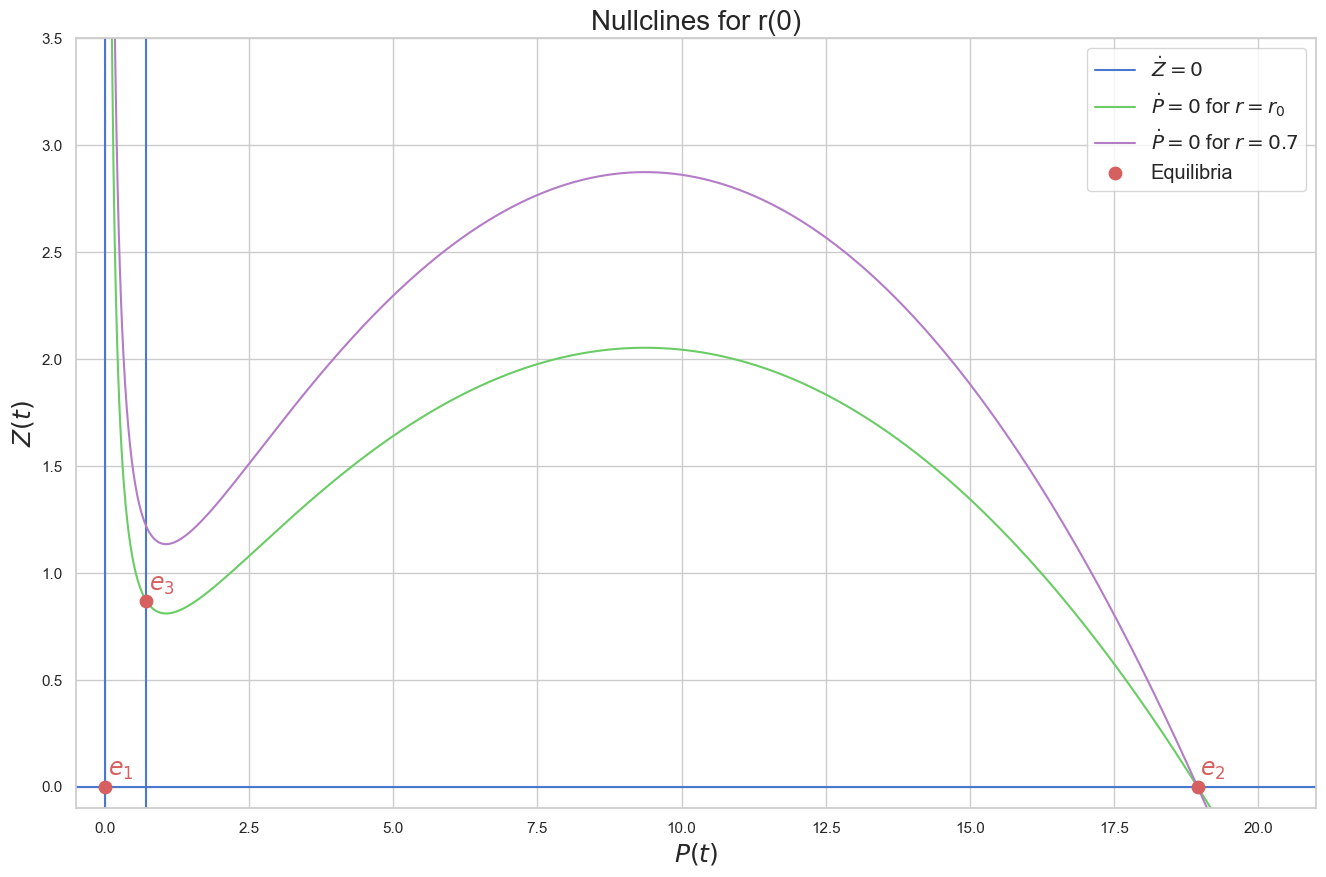

In [59]:
def nullc(r=r,beta=beta,gamma=gamma,epsilon=epsilon,title=r"Nullclines for r(0)"):
    #sns.set(style="whitegrid")

    fig, ax = plt.subplots(figsize=(16, 10))
    
    # analytically estimated equilibria
    equil = np.array([[0, 0], [beta, 0], [np.sqrt(1/(gamma-1)),
                                                  (r*gamma*(beta*np.sqrt(gamma - 1) - 1))/( beta*(gamma - 1) )]])

    ax.set_xlabel(r'$P(t)$', fontsize=18)
    ax.set_ylabel(r'$Z(t)$', fontsize=18)

    points = np.linspace(0.05, 20, 2000)

    # z dot = 0 nullclines
    z_line = equil[2, 0]
    ax.axvline(z_line,color=colors[0],label=r"$\dot{Z}=0$")
    ax.axvline(0,color=colors[0])

    # p dot = 0 nullclines
    ax.plot(Q(points, r)[0], Q(points, r)[1],color=colors[1], label=r"$\dot{P}=0$ for $r=r_0$")
    ax.plot(Q(points, 0.7)[0], Q(points, 0.6)[1],color=colors[3], label=r"$\dot{P}=0$ for $r=0.7$")
    ax.axhline(0,color=colors[0])


    ax.scatter(equil[:, 0], equil[:, 1], marker="o",color=colors[2], s=80, label="Equilibria", zorder=2)

    # label equilibria
    i = 1
    while i < 4:
        ax.annotate(r"$e_"+str(i)+r"$", (equil[i-1, 0]+0.05, equil[i-1, 1]+0.05), weight="bold",color=colors[2], size=17, zorder=2)
        i += 1

    ax.set_xlim(-0.5, 21)
    ax.set_ylim(-0.1, 3.5)
    ax.legend(fontsize="large")
    plt.title(title,fontsize=20)
    plt.savefig("Nullclines.png", format="png", bbox_inches="tight")
    plt.show()

nullc()


# Trajectories

In [14]:
def pe3(gamma):
    return 1/np.sqrt(gamma-1)

In [15]:
def z_e3(beta, r):
    return (r*gamma*(beta*np.sqrt(gamma-1)-1))/(beta*(gamma-1))

In [16]:
def Q1(P, beta, r):
    init=0
    Z = np.zeros(len(P))
    for p in P:
        #to avoid divide by zero, this is already catered for by other fixed points so it is safe to omit
        if p == 0:
            Z[init]=0
        else:
            Z[init] = (r/(beta*p))*((beta-p)*(1+p*p))
        init +=1
    return [P,Z]

In [45]:
#@interact(r=(0.01,2.5,0.01), gamma=(1,4,0.1),beta = (0,19,0.1),epsilon=(0,0.09,0.01))
def plot_traj(r=constants[0], gamma=constants[1], epsilon=constants[2], beta = constants[3]):
    
    sns.set(style="whitegrid")
    points = np.linspace(0.05, 20, 2000)
    fig, ax = plt.subplots(figsize=(16,10))
    ax.set_xlabel(r'$P(t)$', fontsize=18)
    ax.set_ylabel(r'$Z(t)$', fontsize=18)

    ze3 = np.sqrt(1/(gamma-1))
    e2eigvec = [beta+0.0001*((beta*beta)/(epsilon*(1 + beta*beta*(1-gamma)) - 1 - beta*beta)),0.0001]
    
    x_0= [
        e2eigvec,
        [0.01,0],
        [23,0],
        [20,3],
        [ze3,equilibria[2,1] -0.21],
        [ze3,equilibria[2,1] -0.2025],
        [ze3,equilibria[2,1] -0.2015],
        [ze3,equilibria[2,1] -0.2],
        [ze3,equilibria[2,1] -0.18],
        [7.5,0.5],
        [0,14]
         ]
    n=10000
    stepsize=0.1
    ax.plot(Q1(points, beta, r)[0], Q1(points, beta, r)[1],color=colors[1], label=r"$\dot{P}=0$ for $r=r_0$")
    #trajectories
    for i in range(0,len(x_0)):
        x = Runge_Kutte_4(model, x_0[i], [r,gamma,epsilon,beta], n, stepsize)
        
        #for the legend
        if i ==1:
            ax.plot(x[:,0],x[:,1], color = 'gray', label="Trajectories")
            ax.plot(x[-1,0],x[-1,1], "ro", label="End Point", ms=6)
            ax.plot(x[0,0],x[0,1,], "ko", label="Start Point", ms=5)
        
        ax.plot(x[:,0],x[:,1], color = 'gray')
        ax.plot(x[-1,0],x[-1,1], "ro", ms=6)
        ax.plot(x[0,0],x[0,1], "ko", ms=5)
    
    ax.set_xlim(-0.5,20)
    ax.set_ylim(-0.5,4)
    ax.legend(fontsize="large")
    plt.savefig("trajectoriespres.png", format="png", bbox_inches="tight")
    plt.show()

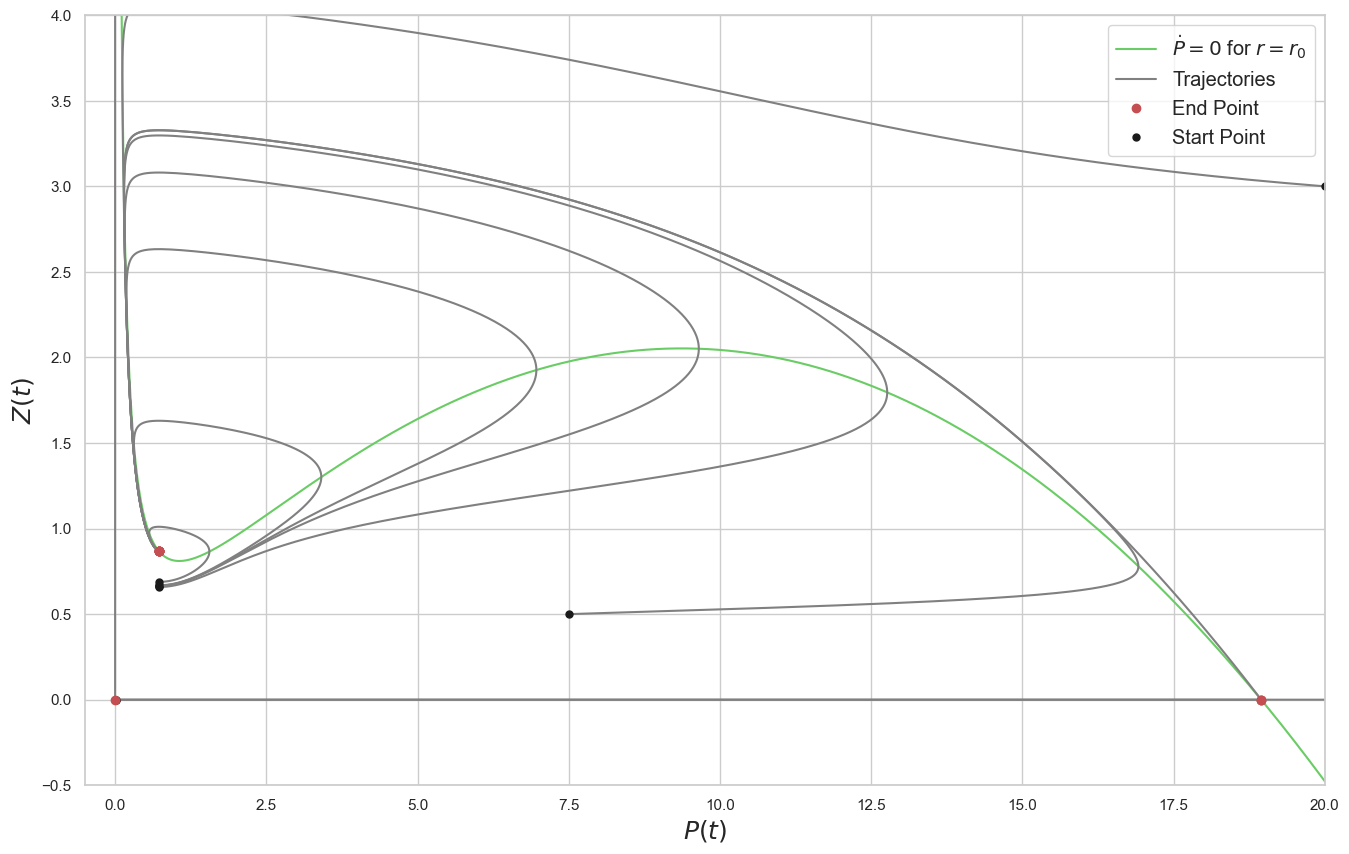

In [46]:
plot_traj(r,gamma,epsilon,beta)

# Excitability

Excitbility by direct perturbation of the population of zooplankton

In [19]:
def excitability(delta, epsy):
    c = equilibria[2,1]
    length = int(c/delta)+1
    p_max = np.zeros(length)
    z = np.zeros(length)
    p0, z0 = [equilibria[2,0], equilibria[2,1]]
    i = 0
    while z0 > 0:
        x0 = [p0,z0]
        x = Runge_Kutte_4(model,x0,constants=[r,gamma,epsy,beta])[:,0]
        p_max[i] = max(x)
        z[i] = z0
        z0 -= delta
        i+=1
    return z, p_max

Note: this cell takes a very long time to run

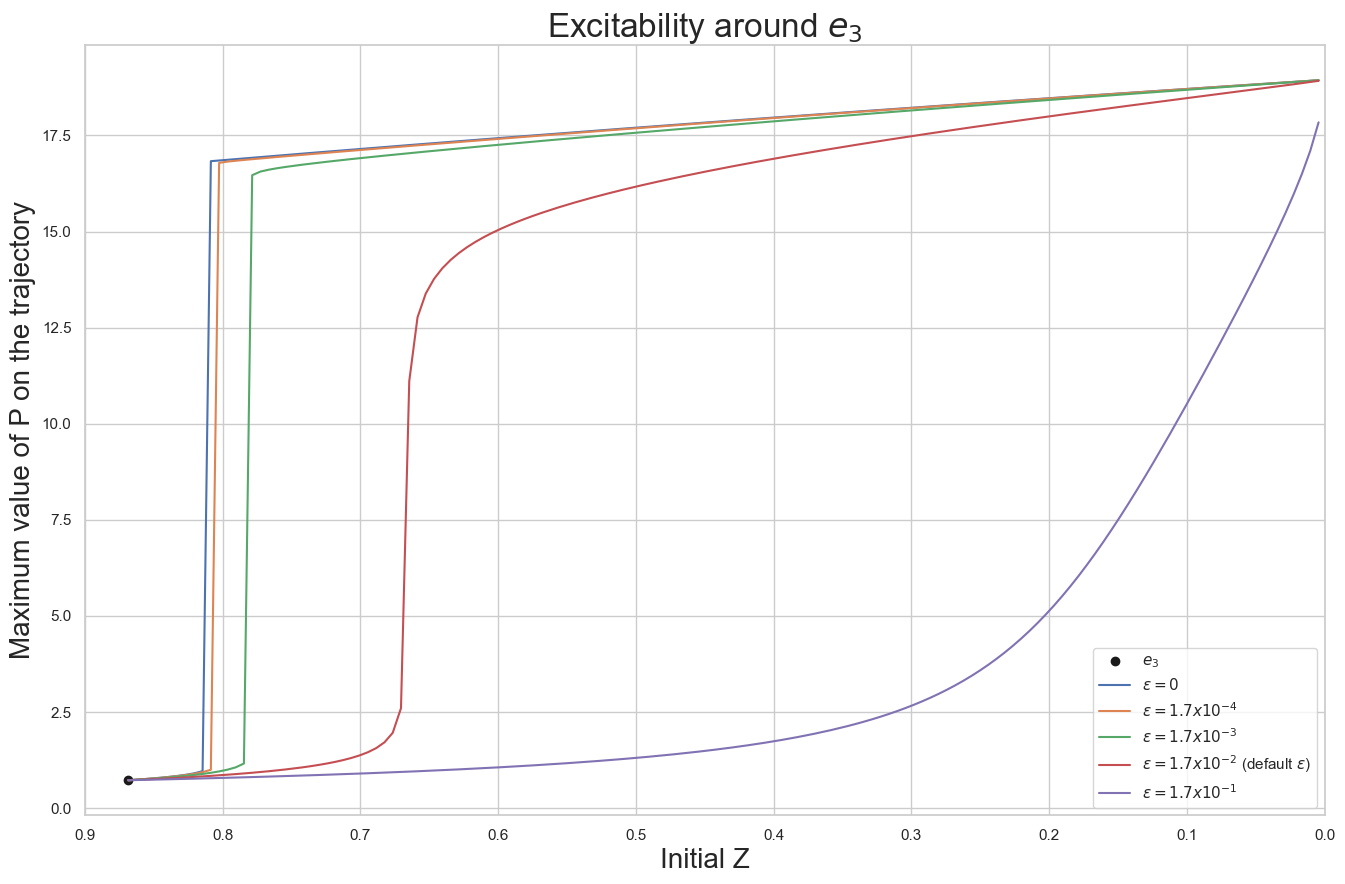

In [20]:
plt.figure(figsize=(16,10))
eps_list = [0, 0.00017, 0.00171, 0.01714, 0.17143]
plt.scatter(equilibria[2,1], equilibria[2,0], color='k', label='$e_3$')
i=5
for epsy in eps_list:
    z, p_max = excitability(0.006,epsy)
    if epsy == 0:
        plt.plot(z,p_max, label = r'$\varepsilon = 0$')
    elif epsy == 0.01714:
        plt.plot(z,p_max, label = r'$\varepsilon = 1.7x10^{-2}$ (default $\varepsilon$)')
    else:
        plt.plot(z,p_max, label = r'$\varepsilon = 1.7x10^{-' + str(i) +'}$')
    i-=1

plt.title(r"Excitability around $e_3$",fontsize=24)
plt.xlim(0.9,0)
plt.xlabel("Initial Z", fontsize = 20)
plt.ylabel("Maximum value of P on the trajectory", fontsize = 20)
plt.legend()
plt.savefig("Excitability.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Eigenvalues

In [21]:
def eigenvals_gamma(gamma,beta):
    a = r - (2*r)/(beta*np.sqrt(gamma-1)) - ( 2*r*gamma*(beta*np.sqrt(gamma - 1) - 1) )/( (gamma)*beta )
    a_squared = a*a
    bc = ( 8*r*epsilon*(np.sqrt(gamma-1))*(beta*np.sqrt(gamma-1)-1) )/( beta*gamma )
    if a_squared < 1e-6:
        lambda1 = np.sqrt(a_squared - bc)
        lambda2 = np.sqrt(a_squared - bc)
        iscomplex = True
        #never has positive real part for beta, gamma > 0, so we can ask if it is complex alone
    else:
        lambda1 = (a + np.sqrt(a_squared - bc))
        lambda2 = (a - np.sqrt(a_squared - bc))
        iscomplex = False
    return lambda1, lambda2, iscomplex

In [22]:
eigenvals_gamma(gamma,beta)

(-0.02534713472408634, -1.4657072415943047, False)

In [23]:
def transcritical_bif(gamma):
    beta = 1/np.sqrt(gamma-1)
    return beta

In [42]:
def hopf_bif(gamma):
    for g in gamma:
        if g == 2:
            g = None
    beta = (2*gamma-4)/(np.sqrt(gamma-1)*(2*gamma-3))
    return beta

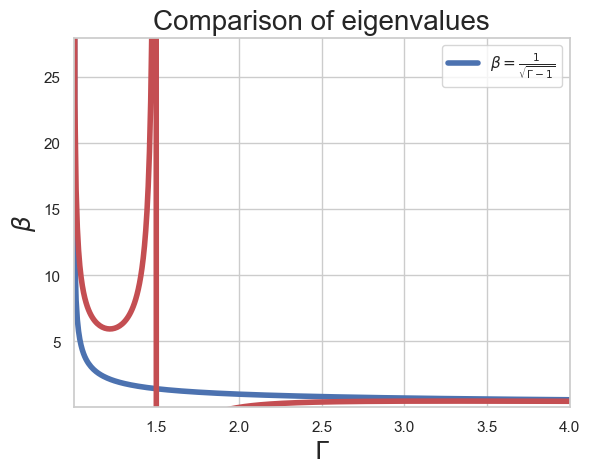

In [43]:
gamma_values = np.linspace(1.0001, 4.0, 400)
beta_values = np.linspace(0.01, 28, 400)
plt.plot(gamma_values, 1/np.sqrt(gamma_values-1), label=r'$\beta = \frac{1}{\sqrt{\Gamma - 1}}$',linewidth=4)
plt.plot(gamma_values, hopf_bif(gamma_values),color='r',linewidth=4)
plt.xlabel(r'$\Gamma$',fontsize=18)
plt.ylabel(r'$\beta$',fontsize=18)
plt.xlim(1.001, 4)
plt.ylim(0.01, 28)
plt.legend()
plt.title('Comparison of eigenvalues',fontsize=20)
plt.savefig("Eigenvaluesgammabeta.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Bifurcation analysis

In [47]:
def equilibria_plot1(Beta):
    fig, ax = plt.subplots(figsize=(12,8))

    e_3_unstable1, e_3_unstable2 = [0,transcritical_bif(gamma)], [transcritical_bif(gamma),transcritical_bif(gamma)]
    e_3_stable1, e_3_stable2 = [transcritical_bif(gamma),25], [transcritical_bif(gamma),transcritical_bif(gamma)]
    #we want to create different linetypes based on the stability of the system
    ax.plot(e_3_unstable1, e_3_unstable2,color='g', linestyle='dashed',linewidth=4)
    ax.plot(e_3_stable1, e_3_stable2, label=r'$e_3$',color='g', linestyle='-',linewidth=4)
    
    ax.axhline(0, label=r'$e_1$',color='r', linestyle='dashed',linewidth=4)
    ax.plot(e_3_unstable1,e_3_unstable1, label=r'$e_2$',linestyle='-',linewidth=4)
    ax.plot(e_3_stable1,e_3_stable1, linestyle='dashed',color='b',linewidth=4)
    ax.scatter(1/np.sqrt(gamma-1),1/np.sqrt(gamma-1),s=50, color='r',label = "Transcritical Bifurcation point", zorder=2)
    plt.legend(fontsize=17)
    plt.ylim(-0.1,2.5)
    plt.xlim(0,2.5)
    plt.title(r"Bifurcation of P in $\beta$", fontsize=25)
    plt.xlabel(r'$\beta$',fontsize=18)
    plt.ylabel('P',fontsize=18)
    plt.savefig("Bifurcation in P.png", format="png", bbox_inches="tight")
    plt.show()
    
    
    
    
def equilibria_plot2(Beta, r):
    fig, ax = plt.subplots(figsize=(12, 8))
    stable_beta = []
    saddle_beta = []
    e3_beta = Beta
    #we want to create different linetypes based on the stability of the system
    
    mask = z_e3(e3_beta, r) >= -0.015
    # Use the mask to filter the original array
    e3_beta = e3_beta[mask]
    
    for beta in Beta:
        if z_e3(beta, r) < 0:
            stable_beta.append(beta)
        else:
            saddle_beta.append(beta)
            
    xstable = np.zeros(len(stable_beta))
    xsaddle = np.zeros(len(saddle_beta))
    #plot the values
    ax.plot(np.array(stable_beta), xstable, linestyle = '-', color='b', label=r'$e_2$',linewidth=4)
    ax.plot(e3_beta, z_e3(e3_beta, r), label=r'$e_3$',color='g', linestyle = '-',linewidth=4)
    ax.plot(np.array(saddle_beta), xsaddle, linestyle = 'dashed', color='b',linewidth=4)
    ax.scatter(1/np.sqrt(gamma-1),0,s=50, color='r',label = "Transcritical Bifurcation point", zorder=2)

    
    plt.legend(fontsize=17)
    plt.ylim(-0.11,1.5)
    plt.xlim(0,10)
    plt.title(r"Bifurcation of Z in $\beta$", fontsize=25)
    plt.xlabel(r'$\beta$',fontsize=18)
    plt.ylabel('Z',fontsize=18)
    plt.savefig("Bifurcation in Z.png", format="png", bbox_inches="tight")
    plt.show()

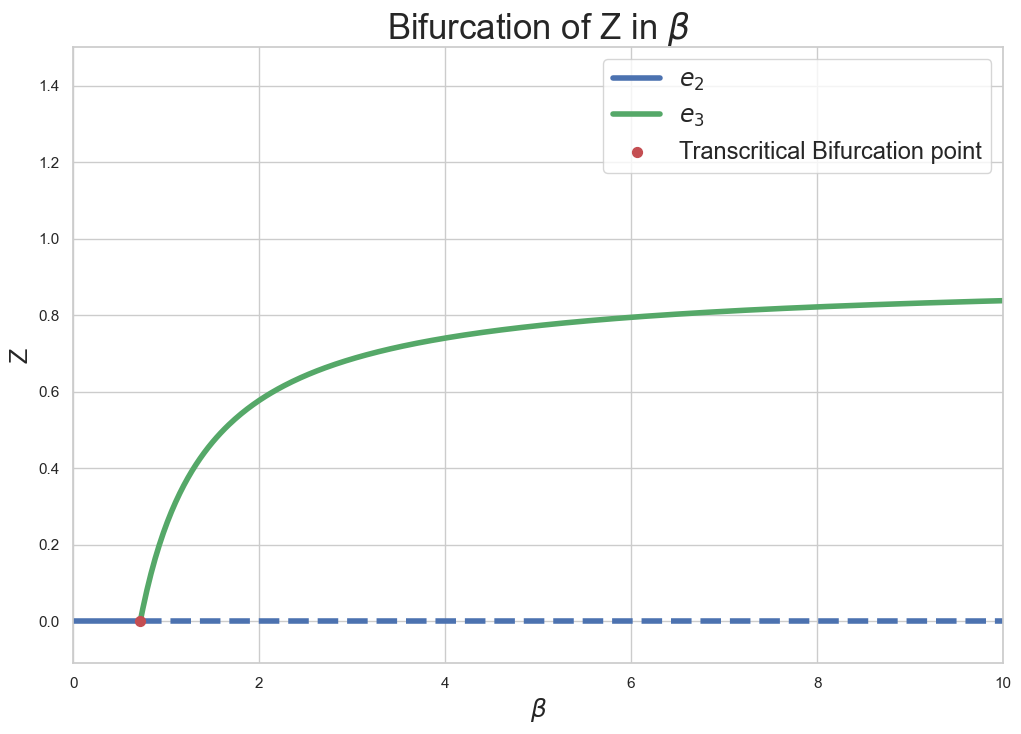

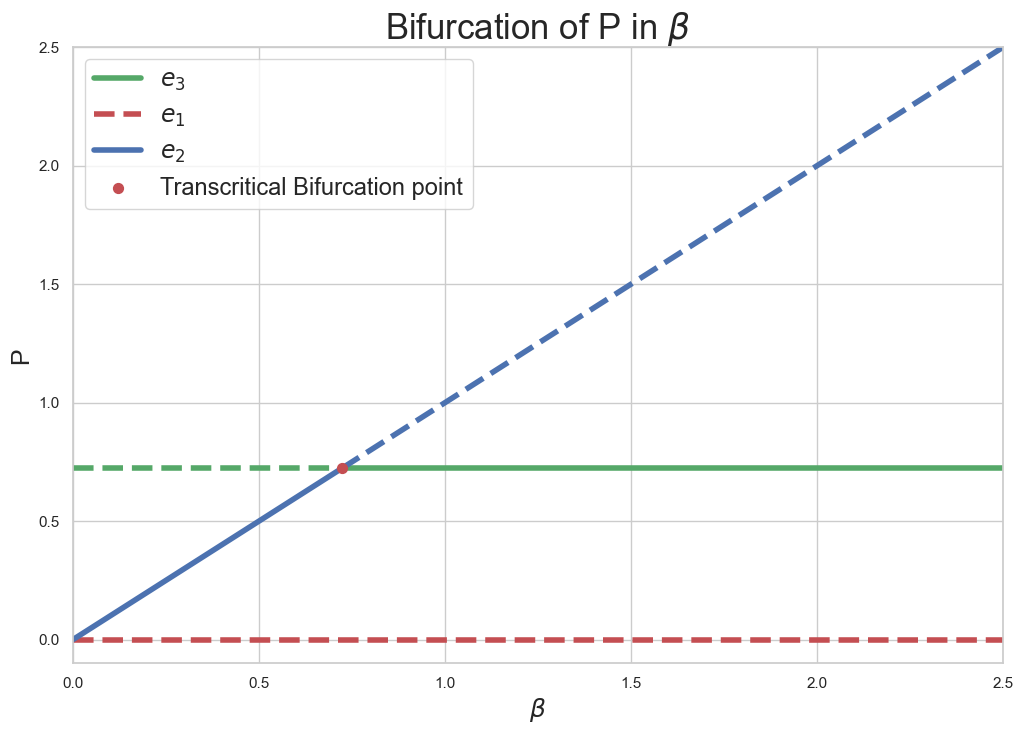

In [48]:
beta_values = np.linspace(0.001,22.0, 1000)
#equilibria_plot1(beta_values)
equilibria_plot2(beta_values,r)
equilibria_plot1(beta_values)


# Slow fast analysis

In [28]:
def Runge_Kutte_4_ramping(f=model, x0=[0,0], constants=constants, n=1000, stepsize=0.1):
    
    t_points = np.linspace(0, n*stepsize, n)
    x = np.zeros((n, 2))
    x[0] = np.array(x0)
    h = stepsize
    
    for i in range(0,n-1):
        k1 = h*f(x[i], constants)
        
        k2 = h*f(x[i]+0.5*k1, constants)
        
        k3 = h*f(x[i]+0.5*k2, constants)
        
        k4 = h*f(x[i]+k3, constants)
        
        x[i+1] = x[i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
    
    return x,t_points

In [29]:
def slow_time(P,r):
    z_diff = (r/P)*((1-P/beta))*(P*P*(gamma-1)-1)
    return z_diff

def slow_time_z(P,r):
    beta=constants[3]
    z = (r/P)*(1-(P/beta))*(1+ P*P)
    return z

def fast_time(P,r,beta=beta,z=equilibria[2,1]):
    p_diff = r*P*(1-(P/beta)) - (z*(P*P))/(1+P*P)
    return p_diff

def real_roots_cubic_plot(r, beta):
    z=5/5.7
    k = r/beta
    return -27*(k*k*r*r) + 18*k*(k+z)*r*r - 4*k*((k+z)**3) - 4*(r**4) + r*r*(k+z)*(k+z)


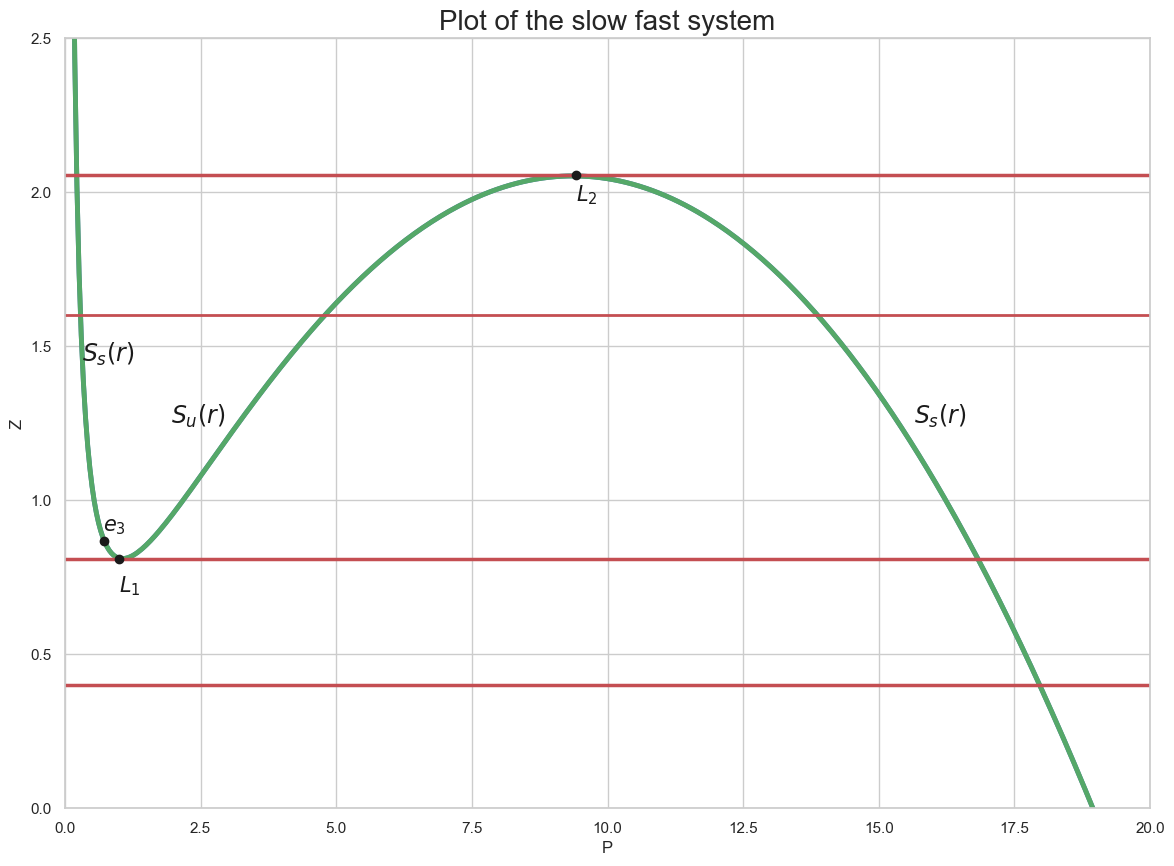

In [49]:
p_values=np.linspace(0.1,20,500)
plt.figure(figsize=(14,10))
plt.plot(p_values,slow_time_z(p_values,r),label='Slow Manifold',linewidth=3.5,zorder=1)
plt.plot(p_values,Q(p_values,r)[1], label='Position of equilibria',color='g',linewidth=3.5)
plt.axhline(1.6,color='r',label='Movement of the layer system',linewidth=2.)
plt.axhline(0.808,color='r',linewidth=2.5)
plt.axhline(0.4,color='r',linewidth=2.5)
plt.axhline(2.055,color='r',linewidth=2.5)
plt.text(1.95,1.25,r'$S_u(r)$',color='k',fontsize=17)
plt.text(0.32,1.45,r'$S_s(r)$',color='k',fontsize=17)
plt.text(15.65,1.25,r'$S_s(r)$',color='k',fontsize=17)
plt.scatter(equilib(r)[2:,0],equilib(r)[2:,1],color='k',zorder=2)
plt.text(9.415,1.97,r'$L_2$',color='k',fontsize=15)
plt.scatter(9.415,2.055,color='k',zorder=2)
plt.text(0.7,0.9,r'$e_3$',color='k',fontsize=15)
plt.scatter(1.0,0.81,color='k',zorder=2)
plt.text(1,0.7,r'$L_1$',color='k',fontsize=15)
plt.title('Plot of the slow fast system',fontsize=20)
plt.xlim(0,20)
plt.ylim(0,2.5)
plt.xlabel('P')
plt.ylabel('Z')
plt.savefig("SlowFast.png", format="png", bbox_inches="tight")

# Parameter Ramping r(t)

In [31]:
def Runge_Kutte_4_ramping(f=model_slow, x0=equilib(r)[2], r_2=0.6, c=5):
    
    h=0.01
    n=50000

    #initialize x
    x = np.zeros((n+1, 2))
    #our starting point
    x[0] = np.array(x0)
    r_list=[]

    if c != 0:
        #values for t
        t_points = np.linspace(0, n*h, n).tolist()
        r_new=r
        i = 0
        while t_points[i] < (r_2-r)/c:
            
            r_new = r + c*t_points[i]
            r_list.append(r_new)
            
            k1 = h*f(x[i], [r_new,gamma,epsilon,beta])
        
            k2 = h*f(x[i]+0.5*k1, [r_new,gamma,epsilon,beta])
        
            k3 = h*f(x[i]+0.5*k2, [r_new,gamma,epsilon,beta])
        
            k4 = h*f(x[i]+k3, [r_new,gamma,epsilon,beta])
        
            x[i+1] = x[i] + 1/6*(k1 + 2*k2 + 2*k3 + k4)
            
            i+=1
    else:
        i=0
        t_points = np.linspace(0, n*h, n).tolist()     
    #flat r after ramp
    for j in range(i,n):
        r_list.append(r_2)
        k1 = h*f(x[j], [r_2,gamma,epsilon,beta])
        
        k2 = h*f(x[j]+0.5*k1, [r_2,gamma,epsilon,beta])
        
        k3 = h*f(x[j]+0.5*k2, [r_2,gamma,epsilon,beta])
        
        k4 = h*f(x[j]+k3, [r_2,gamma,epsilon,beta])
        
        x[j+1] = x[j] + 1/6*(k1 + 2*k2 + 2*k3 + k4)

    return x, t_points, r_list, c

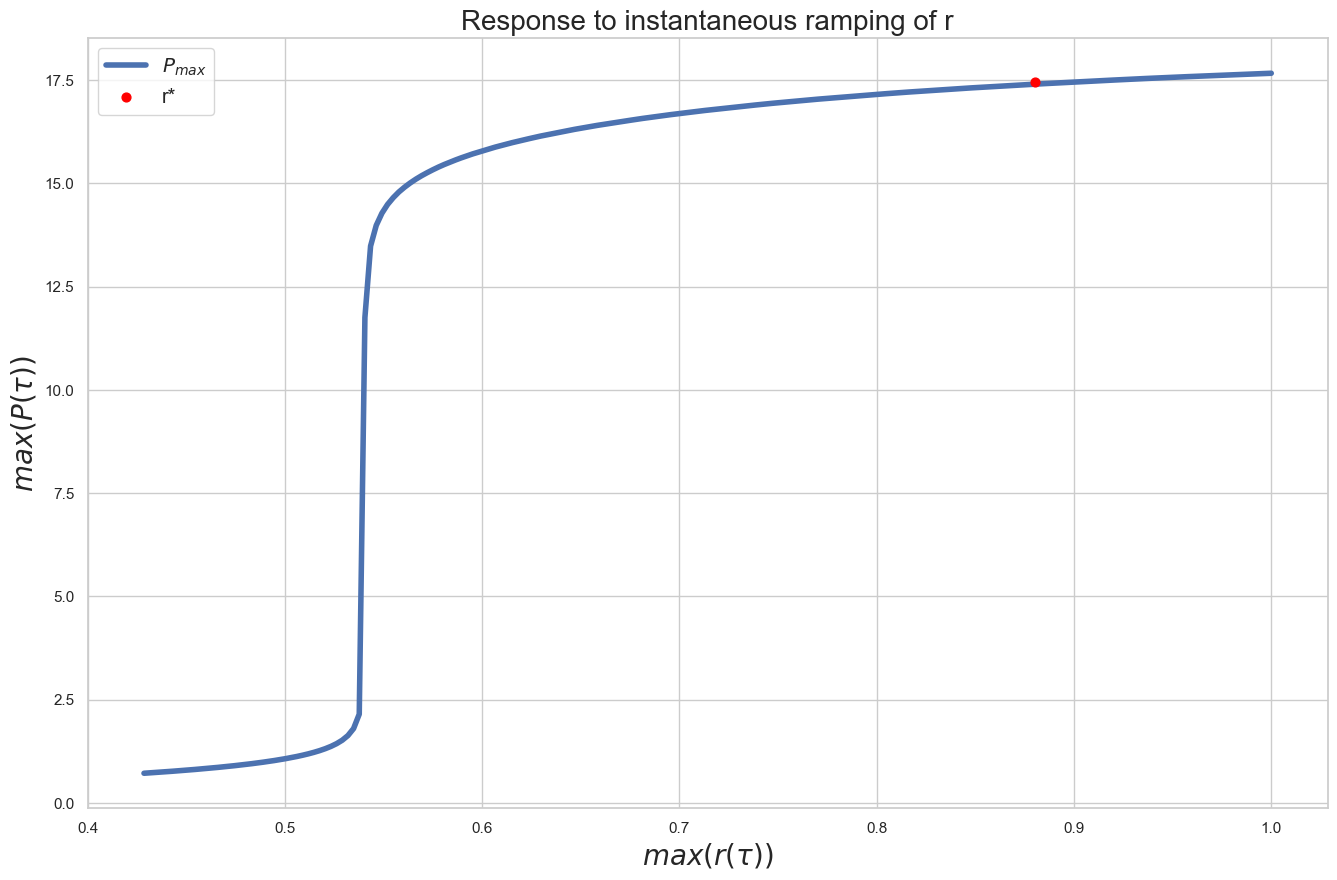

In [32]:
@cache
def plot_r(r_max,linspace):
    p_max_list=[]
    R_maxi = np.linspace(r,r_max,linspace)
    for r_max in R_maxi:
        ramping = Runge_Kutte_4_ramping(model_slow, equilib(r)[2], r_max,0)
        p_max = np.max(ramping[0][:,0])
        p_max_list.append(p_max)

    plt.figure(figsize=(16, 10))
    plt.plot(R_maxi, p_max_list,label=r'$P_{max}$',linewidth=4)
    plt.scatter(0.88,17.45,color='red', label='r*',s=40,zorder=2)
   # plt.axvline(1.6,color='red', label='r*')
    plt.xlabel(r'$max(r(\tau))$', fontsize=20)
    plt.ylabel(r'$max(P(\tau))$', fontsize=20)
    plt.legend(fontsize='large')
   # plt.xlim(r,2.2)
    plt.title('Response to instantaneous ramping of r', fontsize=20)
    plt.savefig("Instantaneous ramping to find r star.pdf", format="pdf", bbox_inches="tight")
    plt.show()
plot_r(1,200)

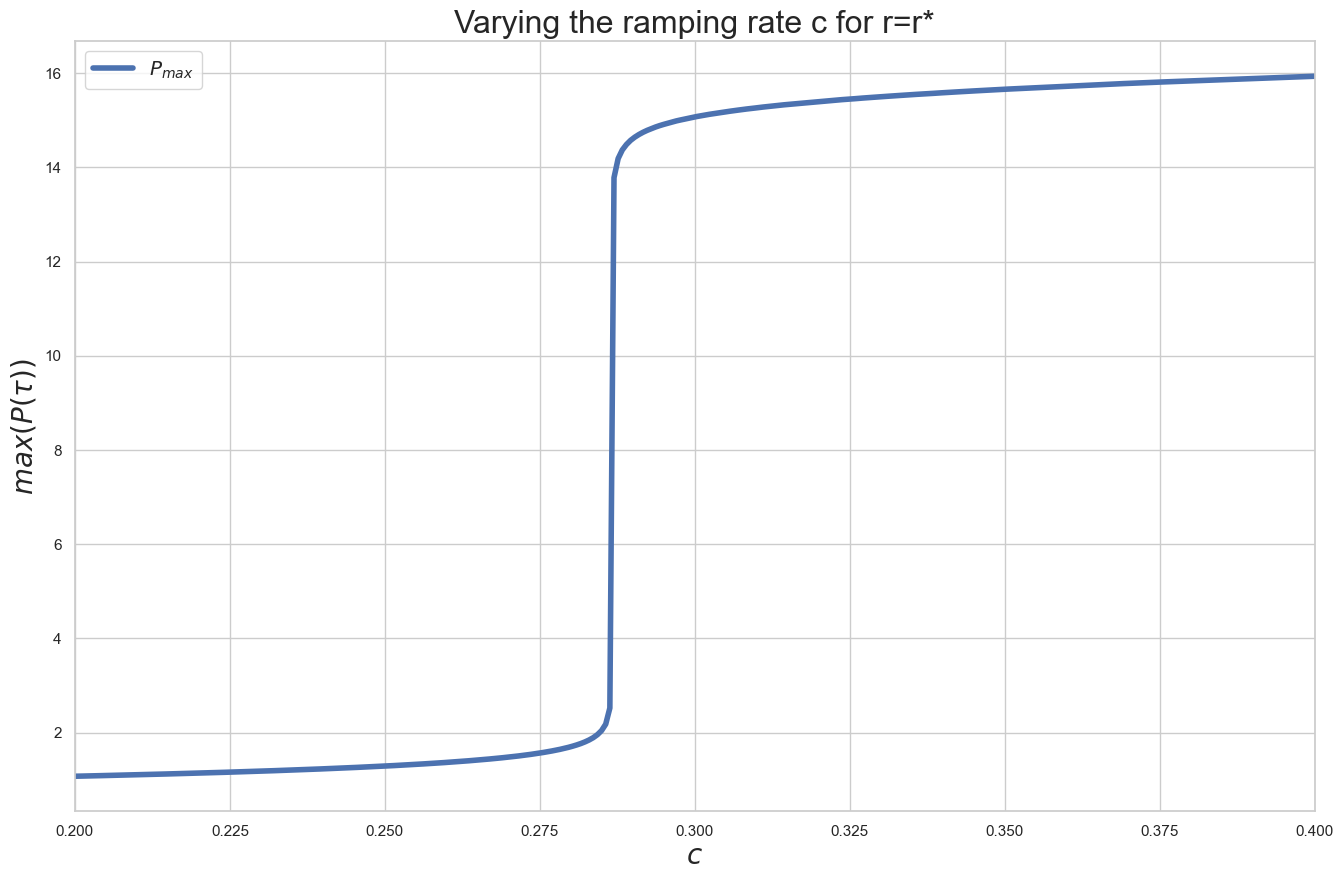

In [53]:
@cache
def plot_c(c_min,c_max,linspace):
    p_max_list=[]
    c_crit = np.linspace(c_min,c_max,linspace)
    for c in c_crit:
        ramping = Runge_Kutte_4_ramping(model_slow, equilib(r)[2], 1.21,c)
        p_max = np.max(ramping[0][:,0])
        p_max_list.append(p_max)

    plt.figure(figsize=(16, 10))
    plt.plot(c_crit, p_max_list,label=r'$P_{max}$',linewidth=4)
    plt.xlabel(r'$c$', fontsize=20)
    plt.ylabel(r'$max(P(\tau))$', fontsize=20)
    plt.xlim(0.2,0.4)
    plt.legend(fontsize='large')
    plt.title('Varying the ramping rate c for r=r*', fontsize=23)
    plt.savefig("Finding critical rate.png", format="png", bbox_inches="tight")
    plt.show()
plot_c(0.4,0.2,300)

In [66]:
#@interact(r_max=(0.5,0.7,0.01), c=(0,0.1,0.01))
def ramping_plot(r_max, c):
    ramping = Runge_Kutte_4_ramping(model_slow,[equilib()[2,0],equilib()[2,1]], r_max, c)
    x = ramping[0]
    t_plot = ramping[1]
    r_plot = ramping[2]
    #end = ramping[3]

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,10))
    plt.suptitle("Ramping with C = "+str(c)+" and r* = "+str(r_max), fontsize=20)
    #ax1
    ax1.set_title("Resulting Trajectory", fontsize=16)
    ax1.set_xlabel(r'$P(\tau)$', fontsize=18)
    ax1.set_ylabel(r'$Z(\tau)$', fontsize=18)

    ax1.plot(x[:,0],x[:,1], color = 'gray',label='Trajectory',linewidth=3,zorder=2)
    ax1.plot(x[-1,0],x[-1,1], "ro", ms=6,label='Final Equilibrium')
    ax1.plot(x[0,0],x[0,1], "ko", ms=5,label='Initial Equilibrium')
    ax1.plot([x[0,0],x[-1,0]], [x[0,1],x[-1,1]], color = 'r', label="path of equilibrium's movement",linewidth=3)

    #plot nullclines
    p_values = np.linspace(0.001,20,1000)
    ax1.plot(p_values,Q(p_values,r_max)[1],label='Slow manifold',color='g',linewidth=4,zorder=1)  

    ax1.set_xlim(-1,16)
    ax1.set_ylim(-0.01, 8)
    ax1.legend(fontsize=14)

    #ax2
    ax2.set_title("Ramping Profile", fontsize=16)
    ax2.set_xlabel(r'$\tau$', fontsize=18)
    ax2.set_ylabel(r'$r(\tau)$', fontsize=18)

    ax2.plot(t_plot, r_plot,color='b',linewidth=4)
    ax2.plot([-300,0],[r,r],color='b',linewidth=4)

    ax2.set_xlim(-10,10)
    ax2.set_ylim(r-0.01,r_max+0.01)
    plt.savefig("Ramping with C = "+str(c)+" and r = "+str(r_max)+".pdf", format="pdf", bbox_inches="tight")
    plt.show()
    #print('Outbreak ended after '+str(end)+' days')

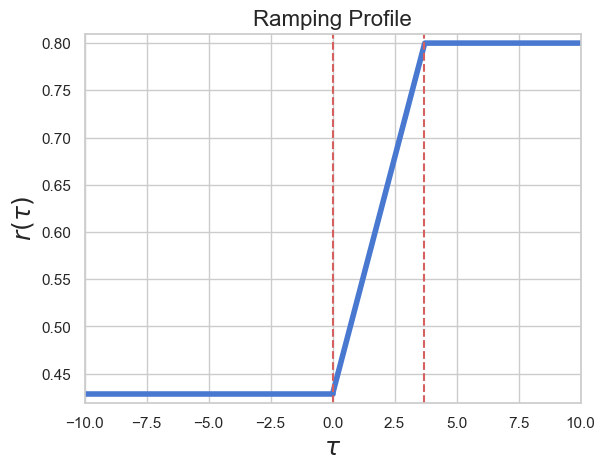

In [52]:
#ax2
c=0.1
r_max=0.8
ramping = Runge_Kutte_4_ramping(model_slow,[equilib()[2,0],equilib()[2,1]], r_max, c)
x = ramping[0]
t_plot = ramping[1]
r_plot = ramping[2]
#end = ramping[3]
plt.title("Ramping Profile", fontsize=16)
plt.xlabel(r'$\tau$', fontsize=18)
plt.ylabel(r'$r(\tau)$', fontsize=18)

plt.plot(t_plot, r_plot,color=colors[0],linewidth=4)
plt.plot([-300,0],[r,r],color=colors[0],linewidth=4)
plt.axvline(0,color=colors[2],linestyle='dashed')
plt.axvline(3.7,color=colors[2],linestyle='dashed')

plt.xlim(-10,10)
plt.ylim(r-0.01,r_max+0.01)
plt.savefig("Ramping profile"+".png", format="png", bbox_inches="tight")

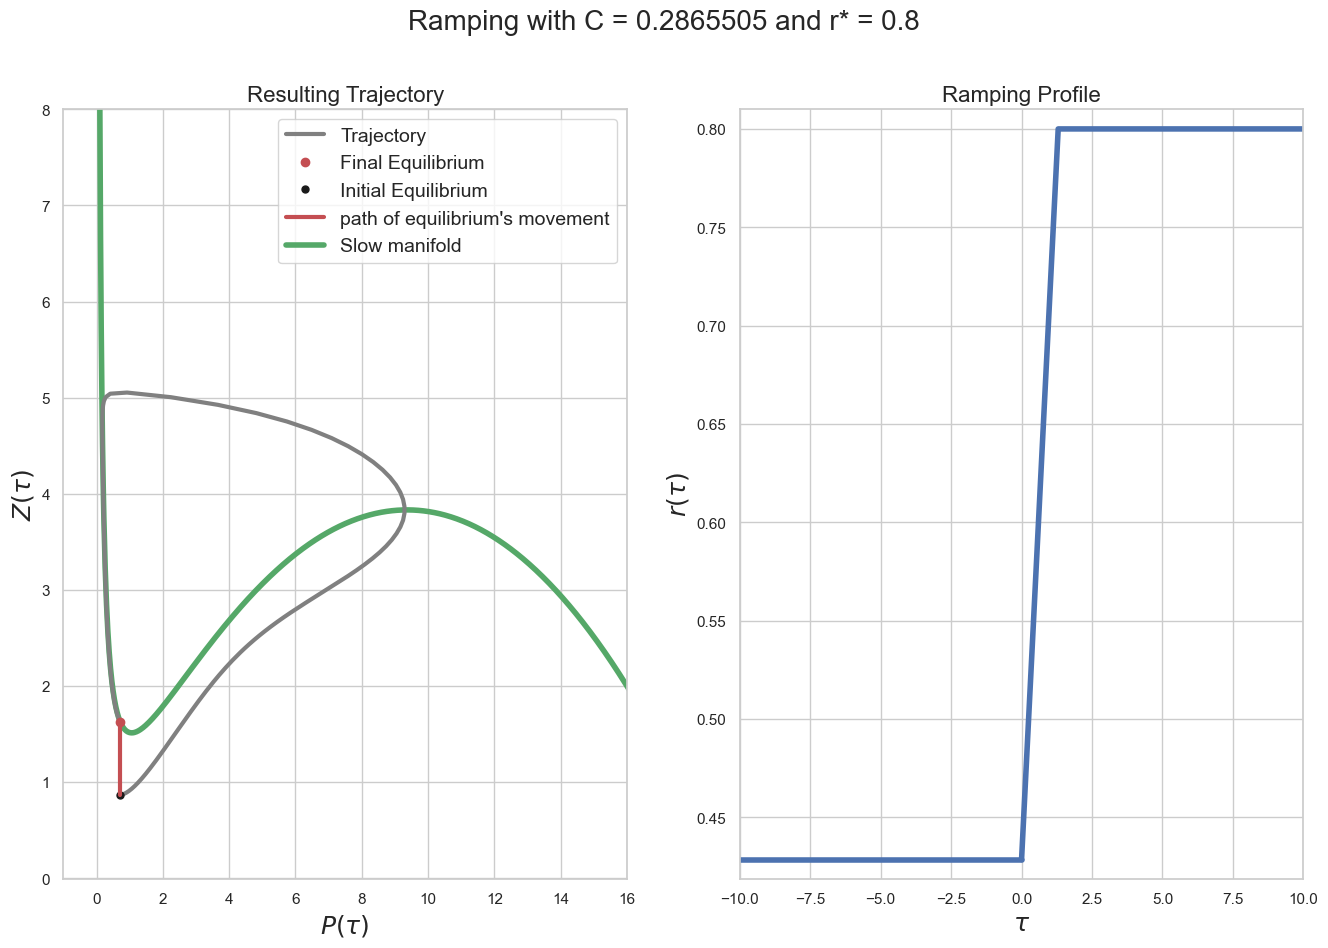

In [67]:
#inputs: value of r, number of days*10, number of iterations, cutlength across day
ramping_plot(r_max=0.8,c=.2865505)

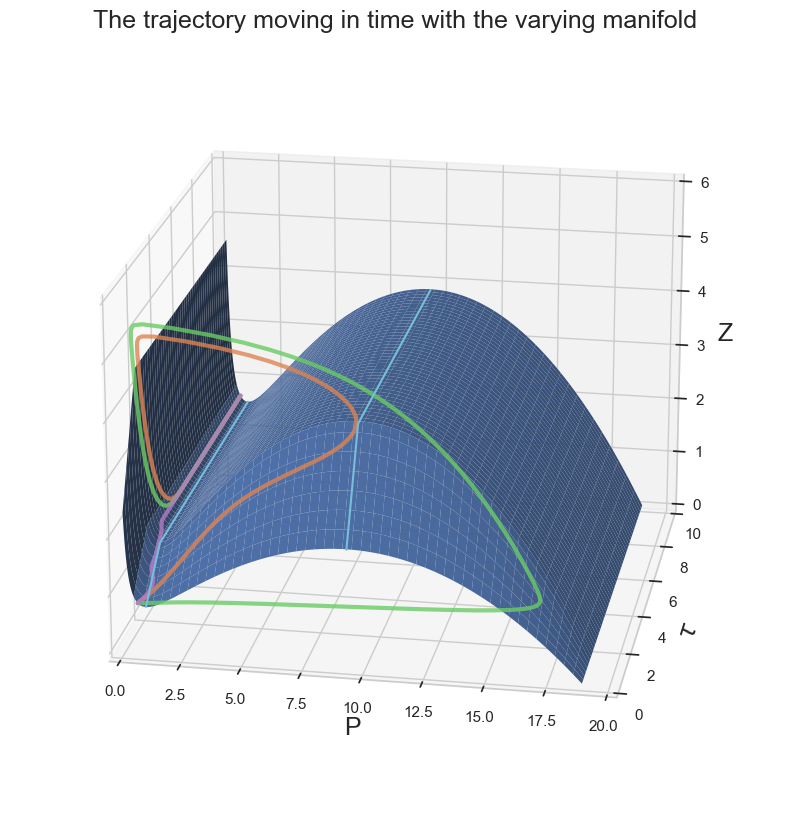

In [37]:

r_max = 0.8
c=0.2865505
ramping = Runge_Kutte_4_ramping(model_slow,equilib(r)[2], r_max, c)
#plot the changing slow manifold as a surface

p_values = np.linspace(0.18,beta,1000)
r_values = ramping[2][0:1000]
t_values = ramping[1][0:1000]


P,t = np.meshgrid(p_values,t_values)
z_list=[]
for i in r_values:
    Z = Q(p_values,i)[1]
    z_list.append(Z)
z_array = np.array(z_list)


fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
ax.plot_surface(P, t, z_array,linewidth=0,alpha=0.96)


x = ramping[0][0:1000]
t_plot = ramping[1][0:1000]
explosive = Runge_Kutte_4_ramping(model_slow,equilib(r)[2], r_max, 0)[0][0:1000]
stable = Runge_Kutte_4_ramping(model_slow,equilib(r)[2], r_max, 0.2)[0][0:1000]


ax.plot(x[:,0], t_plot, x[:,1],label='Trajectory',linewidth=3,alpha=0.8)
ax.plot(explosive[:,0], t_plot, explosive[:,1],label='Trajectory',linewidth=3,alpha=0.8,color=colors[1])
ax.plot(stable[:,0], t_plot, stable[:,1],label='Trajectory',linewidth=3,alpha=0.8,color=colors[3])
ax.plot(np.ones(len(t_plot))*9.36549,t_plot,z_array[:,520],color=colors[5])
ax.plot(np.ones(len(t_plot))*1.0612,t_plot,z_array[:,50],color=colors[5])


ax.set_ylim(0,10)
ax.set_xlim(0,20)
ax.set_zlim(0,6)

ax.set_xlabel('P',fontsize=18)
ax.set_ylabel(r'$\tau$',fontsize=18)
ax.set_zlabel('Z',fontsize=18)





ax.set_title('The trajectory moving in time with the varying manifold',fontsize=18)
ax.view_init(20,280)
plt.savefig("Varying slow manifold.pdf", format="pdf", bbox_inches="tight")
plt.show()



In [38]:
def fixed_slow(p,r,beta=beta,z=5/5.7):
    poly = 4*(p**3)-3*beta*p*p +2*(1+(beta*z/r))*p-beta
    return poly

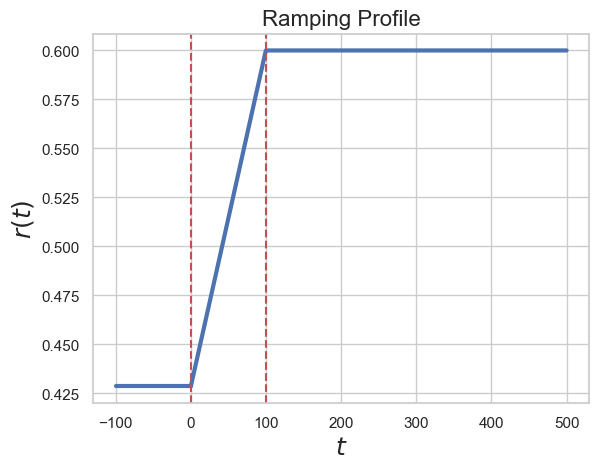

In [51]:
r=constants[0]
r_max=0.6
c = 0.00172
ramping = Runge_Kutte_4_ramping(model,equilibria[2], r_max, c)
t_plot = ramping[1]
r_plot = ramping[2]
plt.plot([-100,0],[r,r],lw=3,color='b')
plt.plot(t_plot,r_plot,lw=3,color='b')
plt.axvline(0,color='r',ls='dashed')
plt.axvline(100,color='r',ls='dashed')

plt.title("Ramping Profile", fontsize=16)
plt.xlabel(r'$t$', fontsize=18)
plt.ylabel(r'$r(t)$', fontsize=18)
plt.savefig("Ramping profile.png", format="png", bbox_inches="tight")

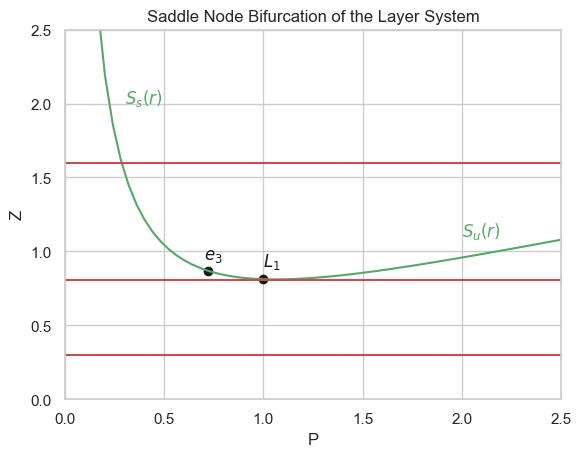

In [50]:

p_values=np.linspace(0.001,20,500)
plt.plot(p_values,Q(p_values,r)[1], label='Position of equilibria',color='g')
plt.axhline(1.6,color='r',label='Movement of the layer system')
plt.axhline(0.808,color='r')
plt.axhline(0.3,color='r')
plt.text(2,1.1,r'$S_u(r)$',color='g')
plt.text(0.3,2,r'$S_s(r)$',color='g')
plt.scatter(equilib(r)[2:,0],equilib(r)[2:,1],color='k')
plt.text(0.7,0.95,r'$e_3$',color='k')
plt.scatter(1.0,0.81,color='k')
plt.text(1,0.9,r'$L_1$',color='k')
plt.title('Saddle Node Bifurcation of the Layer System')
plt.xlabel('P')
plt.ylabel('Z')
plt.xlim(0,2.5)
plt.ylim(0,2.5)
#plt.legend()
#plt.ylim(0.53405,0.5340525)
plt.savefig("Layer saddle node.png", format="png", bbox_inches="tight")
plt.show()